### Ultimate Notebook for Brain Lateralization Paper

Here is the collection of all the analyses performed for the paper on brain lateralization. The analyses are organized in the following way:

1. TVB part
    - Raw Signal examples
    - Apply signal processing to Local Field Potentials (LFPs) on Left and Right pCNG:
        - counting spike frequency in gamma band (30-100 Hz) and theta band (4-8 Hz) after applying a bandpass filter
        - calculate amplitude envelope of the signal
        - include burst analyses (from David's blog: [link](https://spikesandbursts.wordpress.com/2023/08/24/patch-clamp-data-analysis-in-python-bursts/))
        - calculate the coherence between the two LFPs
        - calculate the phase distribution of two signals
    - Structural Connectivity
        - Distribution of left and right tract strengths
        - Distribution of Homotopic and heterotopic connections
        - Weighted Degree Centrality of pCNG
    - Meta Connectivity
        (to be continued)

In [1]:
import sys
sys.path.append('/Users/yilewang/workspaces/')

In [2]:
import numpy as np
import pandas as pd
 
import scipy
from scipy import signal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import skew, kurtosis
 
import matplotlib.pyplot as plt
from os.path import join as pjoin
import tvbtools.tools.burst_detection as bd
import seaborn as sns
from statannotations.Annotator import Annotator

In [3]:
# read mega data
mega_data = pd.read_excel('/Users/yilewang/workspaces/data4project/mega_table.xlsx', sheet_name='tvb_parameters')
# # read k21.txt save as variable k21
# K21 = np.loadtxt(f'/Users/yilewang/workspaces/tvbdemos/clinical_conversion/local_inhibition_lfp/K21.txt', dtype=float)


basedir = "/Users/yilewang/Documents/local_inhibition_only_gc/"

# only_go = pjoin(basedir, "local_inhibition_only_go")
# only_gc = pjoin(basedir, "local_inhibition_only_gc")
# go_gc_K21 = pjoin(basedir, "local_inhibition_lfp_K21")

In [4]:
# create a pd dataframe to save the results
col_names = ['group','caseid', 'gc', "Number_bursts",	"Spikes_Bursts",	"Spikes_Bursts_ratio",	"Mean_Burst_Duration", 
             'mean_isi','median_isi','kurtosis'	,'skewness','cma_threshold'	,'cma_valley_time',	'cma_peak_time', 
             "avg_spike_amp", "avg_inst_freq", "avg_spike_peak"]
bursts_results_left = pd.DataFrame(columns=col_names)
bursts_results_right = pd.DataFrame(columns=col_names)
for case, gr, gc in zip(mega_data.caseid[:74], mega_data.group[:74], mega_data.Gc[:74]):
    # read the data
    filename = pjoin(basedir, gr, f"{case}_{gc}.npy")
    lfp = np.load(filename)
    # pCNG_l = lfp[8192:,0, 4, 0]
    # pCNG_r = lfp[8192:,0, 5, 0]
    pCNG_l = np.mean(lfp, axis=3)[8192:,0,4]
    pCNG_r = np.mean(lfp, axis=3)[8192:,0,5]

    # for the right
    spikes_table_right = bd.generate_spikes_analyses(data=pCNG_r, fs=81920)
    bursts_table_right = bd.bursts_detection(spikes_table_right, 'spike_time', 
                         'spike_amplitude',
                         'spike_peak',
                         n_spikes = 2,  
                         max_isi = 0.1,
                         # min_duration = 0.5,  # Optional
                         min_ibi = 0.2)
    bursts_stats_right = bd.generate_bursts_stats(caseid=case, bursts_table=bursts_table_right, spikes_table=spikes_table_right)
    isi_right = bd.generate_ISI_analyses(spikes_table_right)
    
    # average spike amplitude
    if len(spikes_table_right)==0:
        avg_spike_amp_right = 0
    else:
        avg_spike_amp_right = np.mean(spikes_table_right.spike_amplitude)
    # average instant frequency
    if len(spikes_table_right)==0:
        avg_inst_freq_right = 0
    else:
        avg_inst_freq_right = np.mean(spikes_table_right.inst_freq[1:])
    # average spike peak
    if len(spikes_table_right)==0:
        avg_spike_peak_right = 0
    else:
        avg_spike_peak_right = np.mean(spikes_table_right.spike_peak)


    # create single pd dataframe and concat later
    _a =[ gr,case, gc]
    _b = [*bursts_stats_right.values.ravel()][1:]
    _c = [*isi_right.values.ravel()]
    _d = [avg_spike_amp_right, avg_inst_freq_right, avg_spike_peak_right]
    # concate the list _a _b _c
    _one = _a + _b + _c + _d

    _single = pd.DataFrame(_one, index=col_names)
    bursts_results_right = pd.concat([bursts_results_right, _single.T], axis=0)


    # for the left
    spikes_table_left = bd.generate_spikes_analyses(data=pCNG_l, fs=81920)
    bursts_table_left = bd.bursts_detection(spikes_table_left, 'spike_time', 
                         'spike_amplitude',
                         'spike_peak',
                         n_spikes = 2,  
                         max_isi = 0.1,
                         # min_duration = 0.5,  # Optional
                         min_ibi = 0.2)
    bursts_stats_left = bd.generate_bursts_stats(caseid=case, bursts_table=bursts_table_left, spikes_table=spikes_table_left)
    isi_left = bd.generate_ISI_analyses(spikes_table_left)

    # average spike amplitude
    if len(spikes_table_left)==0:
        avg_spike_amp_left = 0
    else:
        avg_spike_amp_left = np.mean(spikes_table_left.spike_amplitude)
    # average instant frequency
    if len(spikes_table_left)==0:
        avg_inst_freq_left = 0
    else:
        avg_inst_freq_left = np.mean(spikes_table_left.inst_freq[1:])
    # average spike peak
    if len(spikes_table_left)==0:
        avg_spike_peak_left = 0
    else:
        avg_spike_peak_left = np.mean(spikes_table_left.spike_peak)


    # create single pd dataframe and concat later
    _a =[ gr,case, gc]
    _b = [*bursts_stats_left.values.ravel()][1:]
    _c = [*isi_left.values.ravel()]
    _d = [avg_spike_amp_left, avg_inst_freq_left, avg_spike_peak_left]
    # concate the list _a _b _c
    _one = _a + _b + _c + _d
    _single = pd.DataFrame(_one, index=col_names)
    bursts_results_left = pd.concat([bursts_results_left, _single.T], axis=0)


bursts_results_left.to_csv(pjoin(basedir, "bursts_results_left2.csv"), index=False)
bursts_results_right.to_csv(pjoin(basedir, "bursts_results_right2.csv"), index=False)

No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected
No spikes detected


In [5]:
bursts_results_left = pd.read_csv(pjoin(basedir, "bursts_results_left2.csv"))
bursts_results_right = pd.read_csv(pjoin(basedir, "bursts_results_right2.csv"))
ta = bursts_results_right
col = ta.columns[3:]

# for var in col:
#     figure = plt.figure(figsize=(10, 5))
#     sns.violinplot(x="group", y=var, data=ta, cut=0, inner = None)
#     sns.stripplot(x="group", y=var, data=ta, dodge=True, jitter=True, color='black')
#     sns.pointplot(x="group", y=var, data=ta, color='r', errorbar=None)


In [6]:

def before_after_graph(befores, afters, ax, ylim=[-0.5, 35]):
    # plotting the points
    ax.scatter(np.zeros(len(befores)), befores, s=1, color='k')
    ax.scatter(np.ones(len(afters)), afters, s=1, color='k')
    # plotting the lines
    for i in range(len(befores)):
        ax.plot( [0,1], [befores[i], afters[i]], alpha=0.2, color='k')
    # hide the frame
    sns.despine(top=True, right=True, left=True)
    # ax.set_xticks([0.25, 0.75], ['gc', 'gc_K21'])
    ax.set_xticks([])
    # find max of befores and afters
    ax.set_ylim(ylim)


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

SNC_l vs. SNC_r: Mann-Whitney-Wilcoxon test two-sided, P_val:5.740e-03 U_stat=1.300e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC_l vs. NC_r: Mann-Whitney-Wilcoxon test two-sided, P_val:3.183e-04 U_stat=3.200e+01
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

MCI_l vs. MCI_r: Mann-Whitney-Wilcoxon test two-sided, P_val:7.876e-08 U_stat=1.560e+02
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00

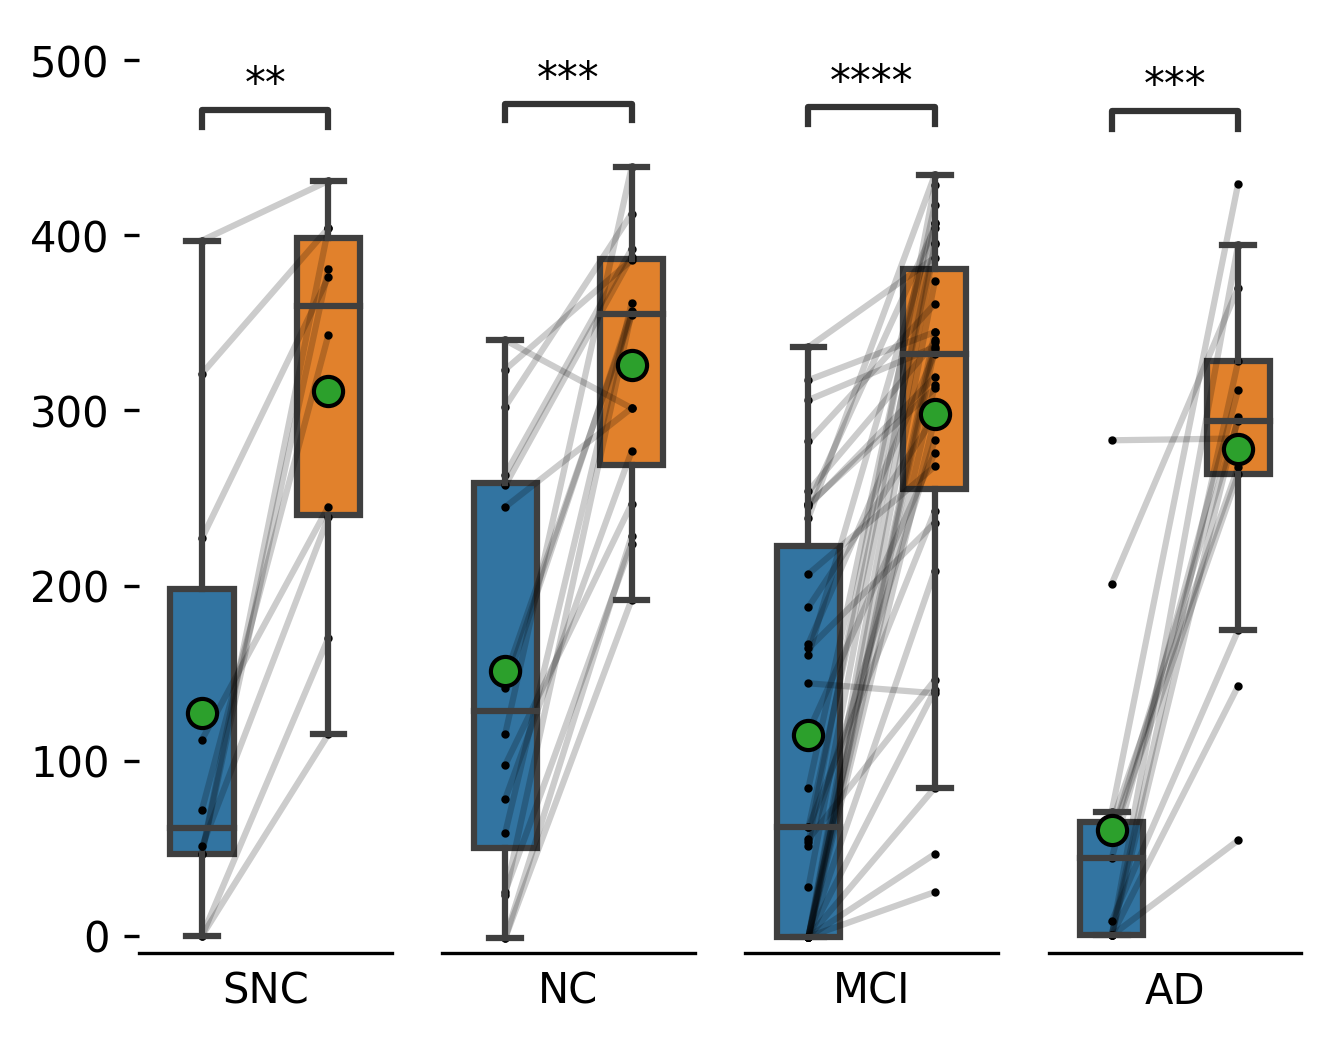

In [10]:
groups = ["SNC", "NC", "MCI", "AD"]
figure = plt.figure(figsize=(5, 4), dpi=300)
ax1 = figure.add_subplot(1, 4, 1)
ax2 = figure.add_subplot(1, 4, 2)
ax2.set_yticklabels([])
ax2.set_yticks([])
ax3 = figure.add_subplot(1, 4, 3)
ax3.set_yticklabels([])
ax3.set_yticks([])
ax4 = figure.add_subplot(1, 4, 4)
ax4.set_yticklabels([])
ax4.set_yticks([])
axs = [ax1, ax2, ax3, ax4]
for gg, ax in zip(groups, axs):
    group_data_before = np.array(bursts_results_left[bursts_results_left.group == gg][bursts_results_left.columns[4]])
    group_data_after = np.array(bursts_results_right[bursts_results_right.group == gg][bursts_results_right.columns[4]])
    before_after_graph(group_data_before, group_data_after, ax=ax, ylim=[-10, 500])
    lr = pd.concat([bursts_results_left.iloc[:,4][bursts_results_left.group == gg], bursts_results_right.iloc[:,4][bursts_results_right.group==gg]], axis=0)
    lrgg = pd.concat([bursts_results_left.group[bursts_results_left.group == gg]+"_l", bursts_results_right.group[bursts_results_right.group==gg]+"_r"], axis=0)
    bp = sns.boxplot(x=lrgg, y=lr, ax=ax, showmeans=True, width=0.5,  showfliers=False, meanprops = {"marker":"o", "markeredgecolor":"black", "markersize":"7"})
    annot = Annotator(ax, [
        ((gg+"_l"), (gg+"_r"))],
        x = lrgg, y = lr)
    annot.configure(test='Mann-Whitney', text_format='star', hide_non_significant=True)
    annot.apply_and_annotate()


    ax.set_ylabel("")
    ax.set_xlabel(gg)
    ax.set_xticklabels("")
    ax.set_xticks([])

In [8]:
# concate burst_results_left.iloc[,4] and burst_results_right.iloc[,4]
bursts_results_left_right = pd.concat([bursts_results_left.iloc[:,4][bursts_results_left.group == "SNC"], bursts_results_right.iloc[:,4][bursts_results_right.group=="SNC"]], axis=0)
print(bursts_results_left_right)

0     72
1     47
2      0
3     47
4     51
5      0
6    397
7    112
8    227
9    321
0    343
1    404
2    115
3    381
4    239
5    170
6    431
7    245
8    376
9    404
Name: Spikes_Bursts, dtype: int64


/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC_Left vs. NC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:2.721e-01 U_stat=1.575e+02
SNC_Left vs. SNC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:1.000e+00 U_stat=5.000e+01
MCI_Left vs. MCI_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:9.342e-01 U_stat=6.200e+02
AD_Left vs. AD_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:5.315e-02 U_stat=4.650e+01


/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC_Left vs. NC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:3.183e-04 U_stat=3.200e+01
SNC_Left vs. SNC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:5.740e-03 U_stat=1.300e+01
MCI_Left vs. MCI_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:7.876e-08 U_stat=1.560e+02
AD_Left vs. AD_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:2.109e-04 U_stat=1.200e+01


/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC_Left vs. NC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:2.378e-04 U_stat=3.000e+01
SNC_Left vs. SNC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:9.082e-03 U_stat=1.500e+01
MCI_Left vs. MCI_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:1.164e-07 U_stat=1.620e+02
AD_Left vs. AD_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:8.681e-03 U_stat=3.300e+01


/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC_Left vs. NC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:5.630e-04 U_stat=3.600e+01
SNC_Left vs. SNC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:1.130e-02 U_stat=1.600e+01
MCI_Left vs. MCI_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:1.023e-07 U_stat=1.600e+02
AD_Left vs. AD_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:1.401e-04 U_stat=1.000e+01


/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC_Left vs. NC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:2.258e-02 U_stat=1.890e+02
SNC_Left vs. SNC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:2.729e-01 U_stat=6.500e+01
MCI_Left vs. MCI_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:6.209e-01 U_stat=6.550e+02
AD_Left vs. AD_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:5.760e-02 U_stat=1.220e+02


/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC_Left vs. NC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:2.870e-02 U_stat=1.865e+02
SNC_Left vs. SNC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:3.845e-01 U_stat=6.200e+01
MCI_Left vs. MCI_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:9.765e-01 U_stat=6.155e+02
AD_Left vs. AD_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:1.006e-01 U_stat=1.170e+02


/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC_Left vs. NC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:6.207e-02 U_stat=1.780e+02
SNC_Left vs. SNC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:2.411e-01 U_stat=6.600e+01
MCI_Left vs. MCI_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:6.716e-01 U_stat=6.490e+02
AD_Left vs. AD_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:1.367e-01 U_stat=1.140e+02


/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC_Left vs. NC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:5.698e-02 U_stat=1.790e+02
SNC_Left vs. SNC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:2.411e-01 U_stat=6.600e+01
MCI_Left vs. MCI_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:7.063e-01 U_stat=6.450e+02
AD_Left vs. AD_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:1.508e-01 U_stat=1.130e+02


/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC_Left vs. NC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:1.524e-02 U_stat=1.900e+02
SNC_Left vs. SNC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:2.463e-01 U_stat=6.450e+01
MCI_Left vs. MCI_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:7.852e-01 U_stat=6.350e+02
AD_Left vs. AD_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:3.199e-01 U_stat=1.040e+02


/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC_Left vs. NC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:6.714e-02 U_stat=1.750e+02
SNC_Left vs. SNC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:3.413e-01 U_stat=6.200e+01
MCI_Left vs. MCI_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:4.113e-01 U_stat=6.795e+02
AD_Left vs. AD_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:2.858e-01 U_stat=1.055e+02


/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC_Left vs. NC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:1.249e-02 U_stat=1.915e+02
SNC_Left vs. SNC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:1.833e-01 U_stat=6.650e+01
MCI_Left vs. MCI_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:3.952e-01 U_stat=6.815e+02
AD_Left vs. AD_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:3.790e-02 U_stat=1.245e+02


/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC_Left vs. NC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:2.411e-03 U_stat=4.700e+01
SNC_Left vs. SNC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:5.777e-03 U_stat=1.300e+01
MCI_Left vs. MCI_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:2.243e-05 U_stat=2.520e+02
AD_Left vs. AD_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:1.464e-03 U_stat=2.200e+01


/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC_Left vs. NC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:9.735e-04 U_stat=4.000e+01
SNC_Left vs. SNC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:5.777e-03 U_stat=1.300e+01
MCI_Left vs. MCI_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:1.023e-07 U_stat=1.600e+02
AD_Left vs. AD_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:1.796e-04 U_stat=1.100e+01


/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(
/Users/yilewang/miniconda3/envs/tvbenv/lib/python3.11/site-packages/statannotations/_Plotter.py:337: UserWarning: Invalid x-position found. Are the same parameters passed to seaborn and statannotations calls? or are there few data points?
  warnings.warn(


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

NC_Left vs. NC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:6.469e-04 U_stat=3.700e+01
SNC_Left vs. SNC_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:5.777e-03 U_stat=1.300e+01
MCI_Left vs. MCI_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:4.139e-06 U_stat=2.210e+02
AD_Left vs. AD_Right: Mann-Whitney-Wilcoxon test two-sided, P_val:2.200e-04 U_stat=1.200e+01


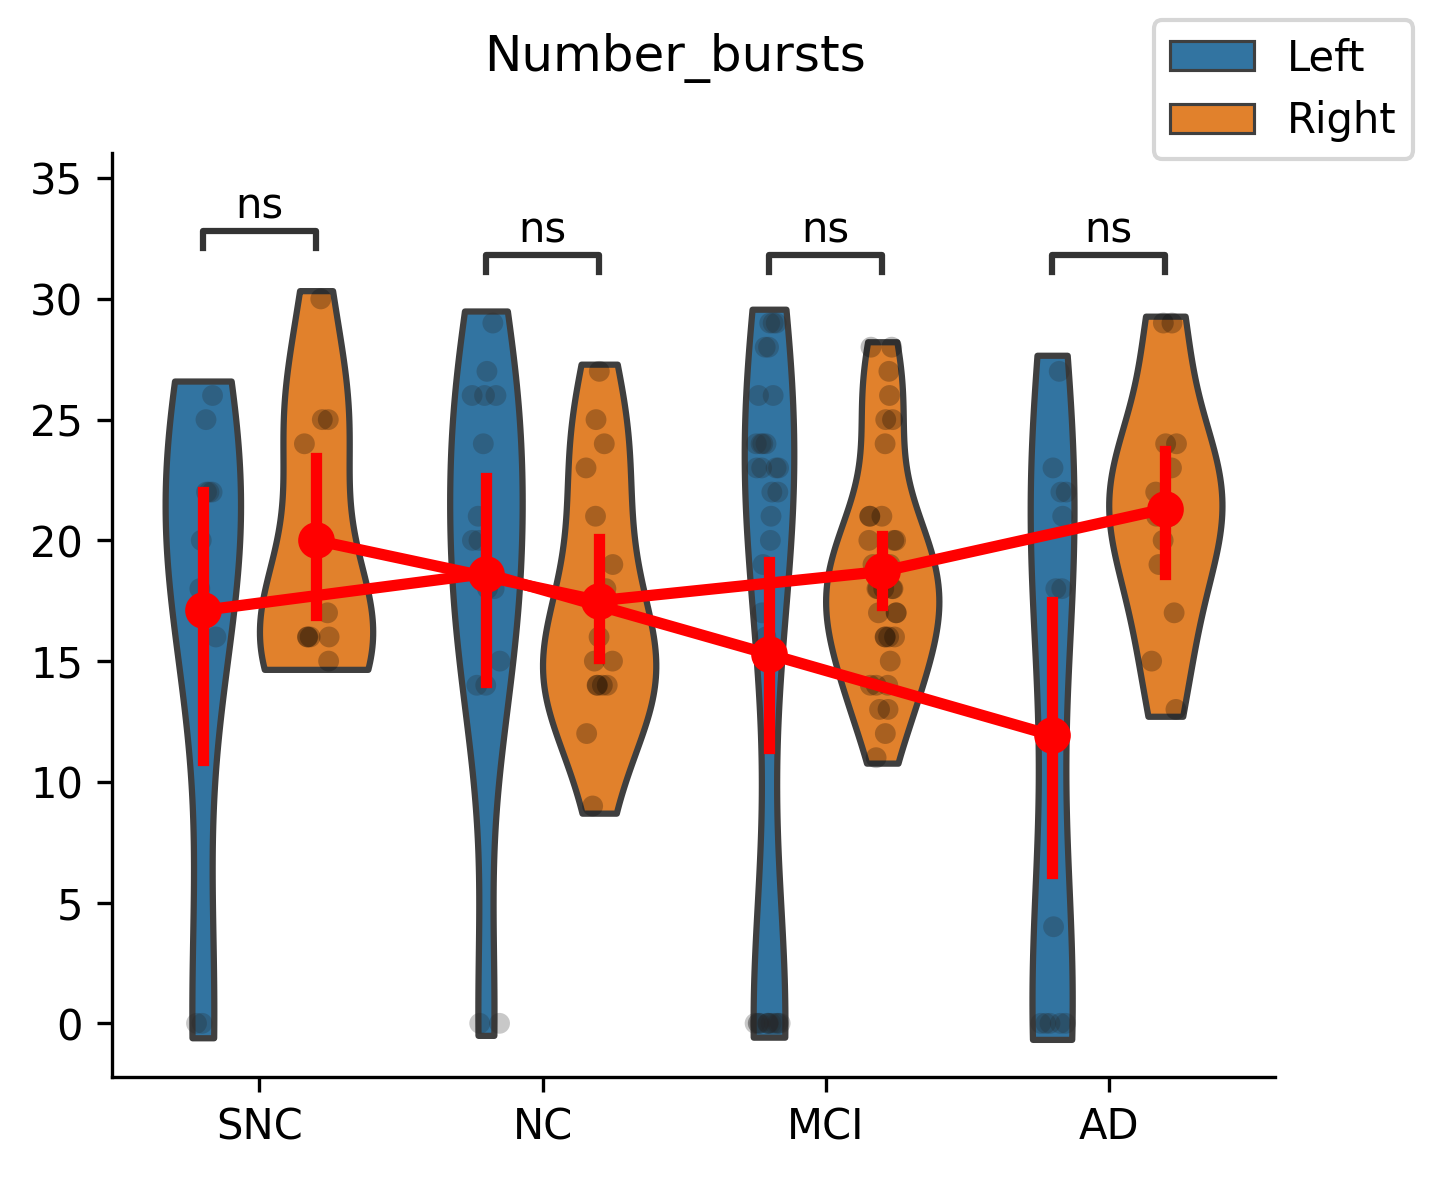

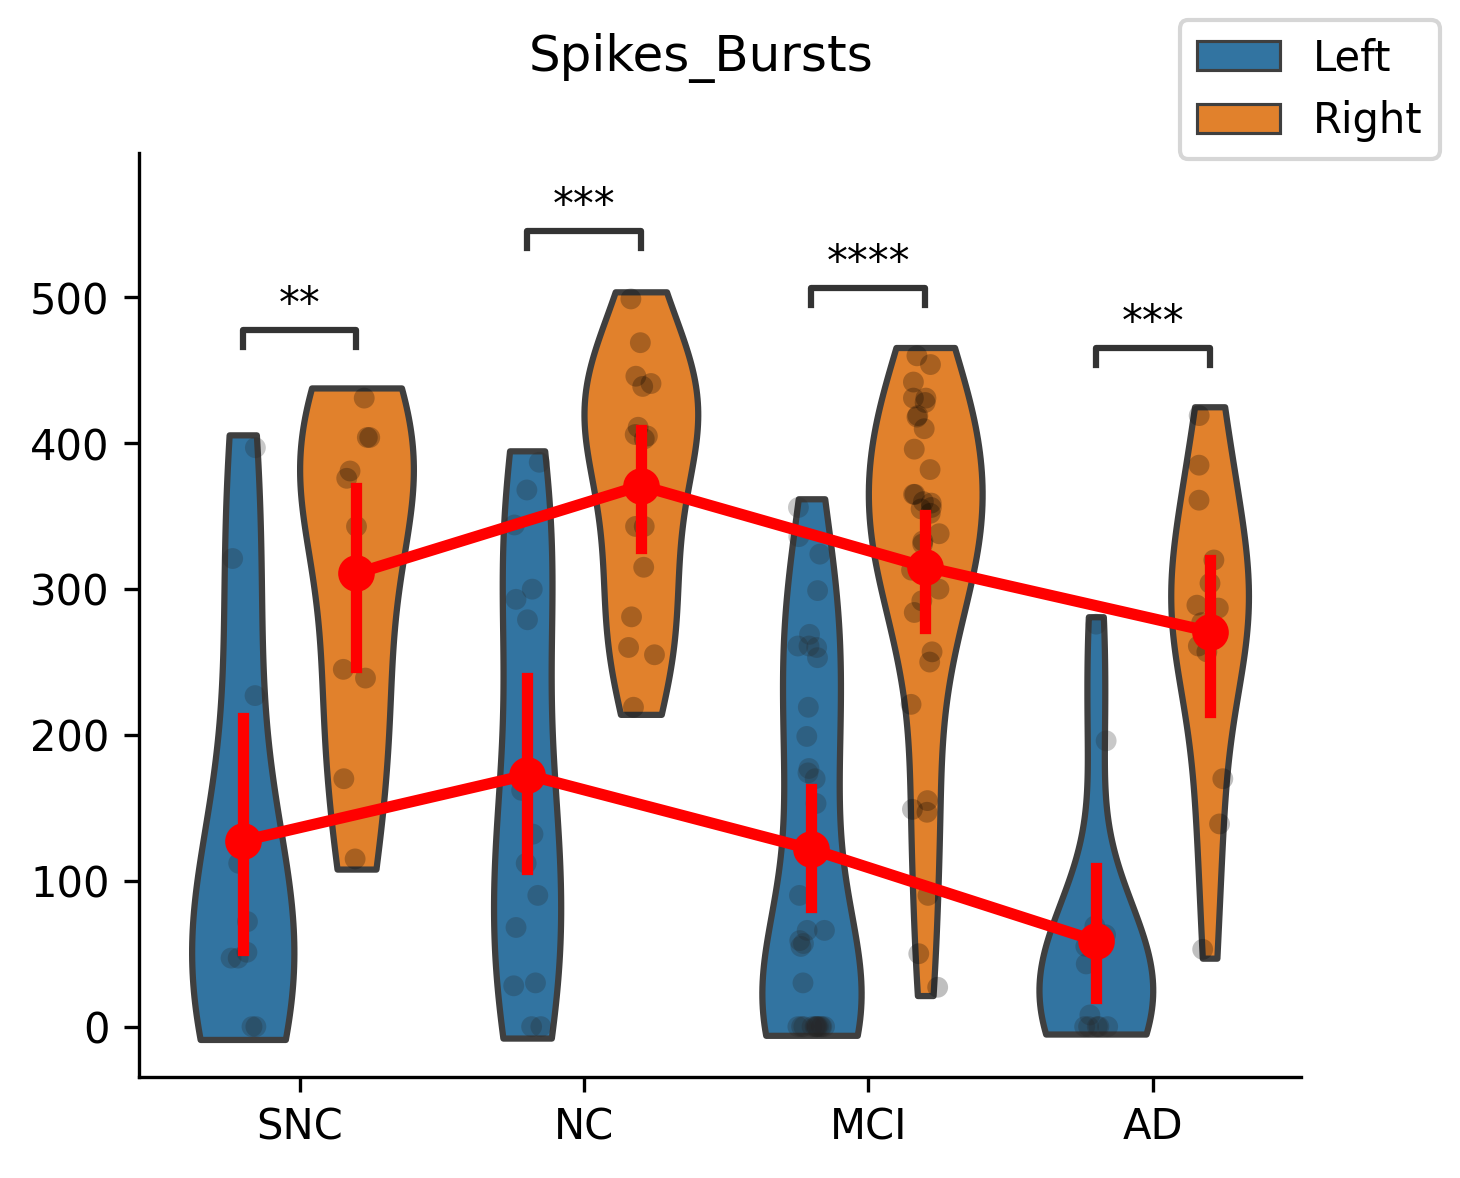

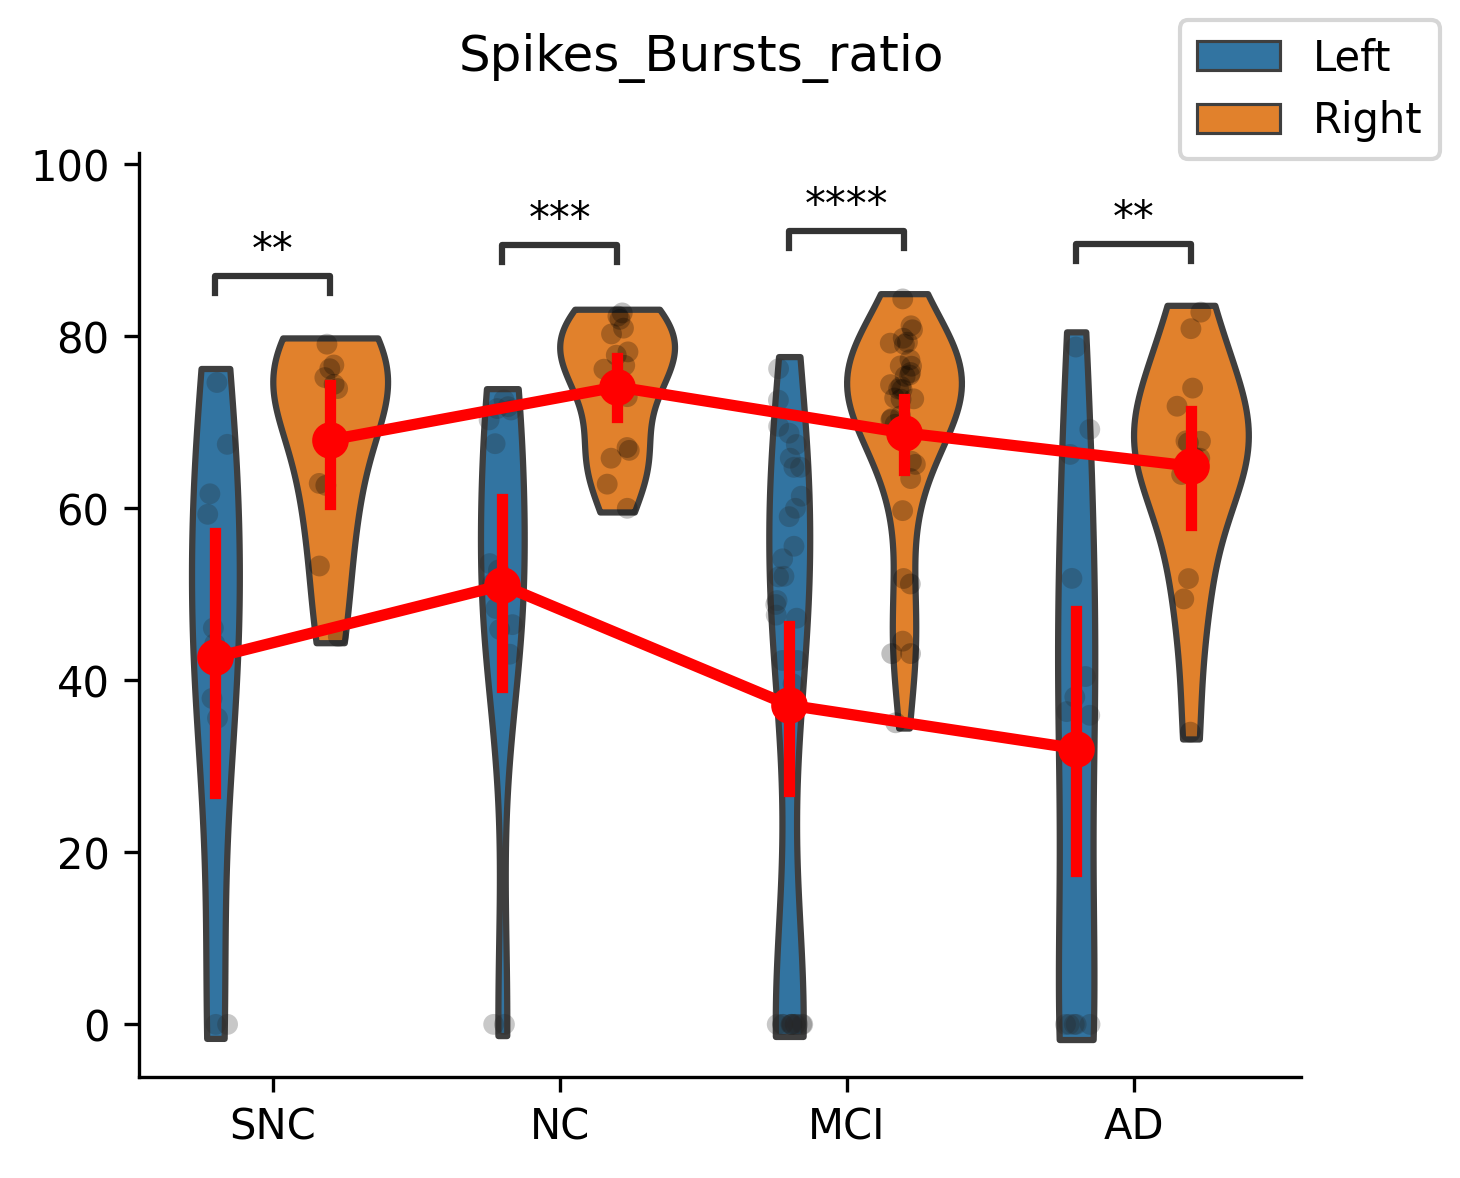

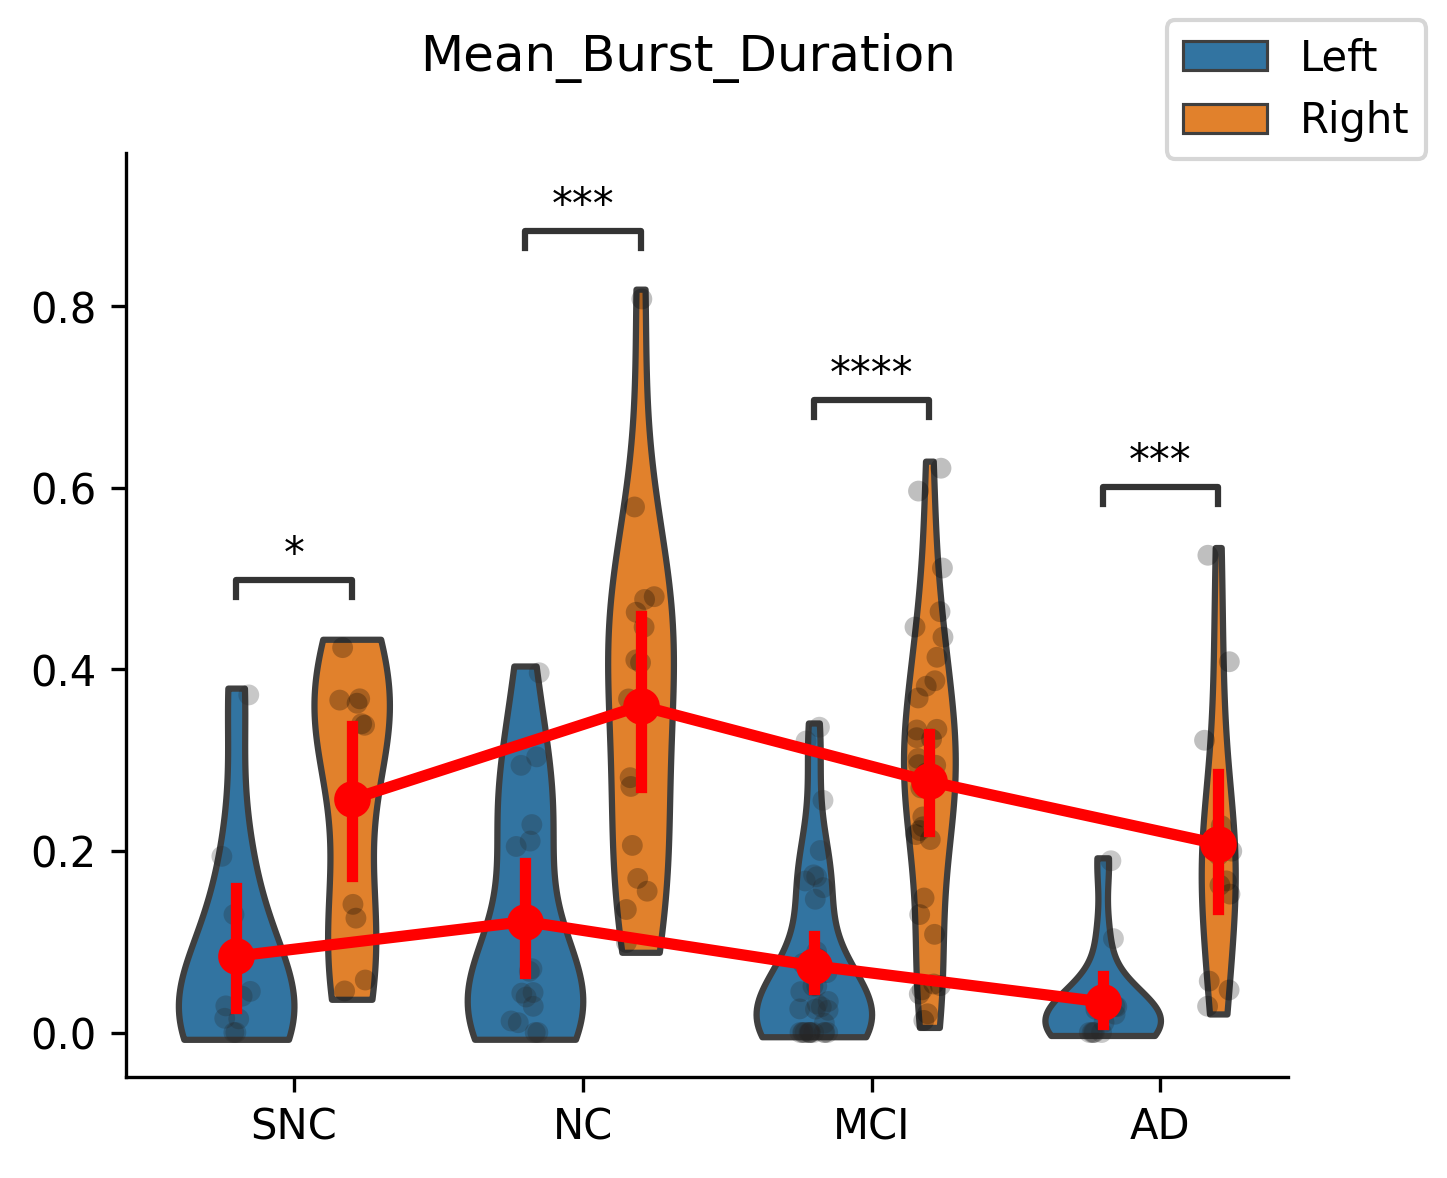

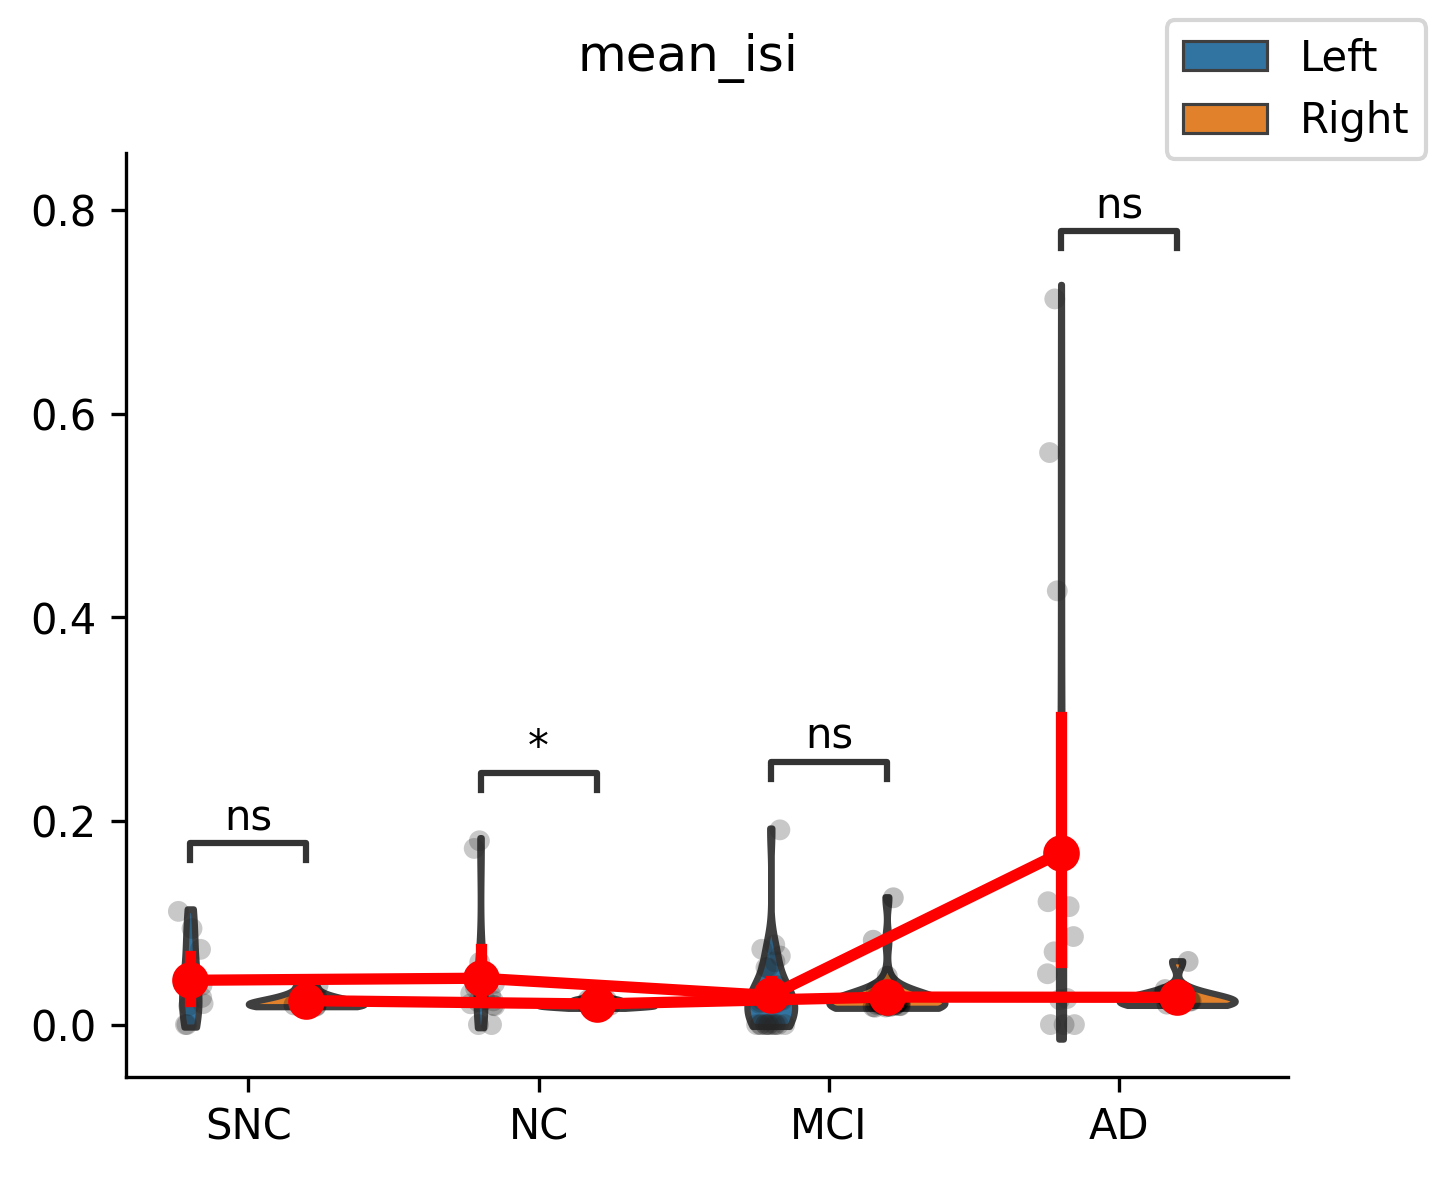

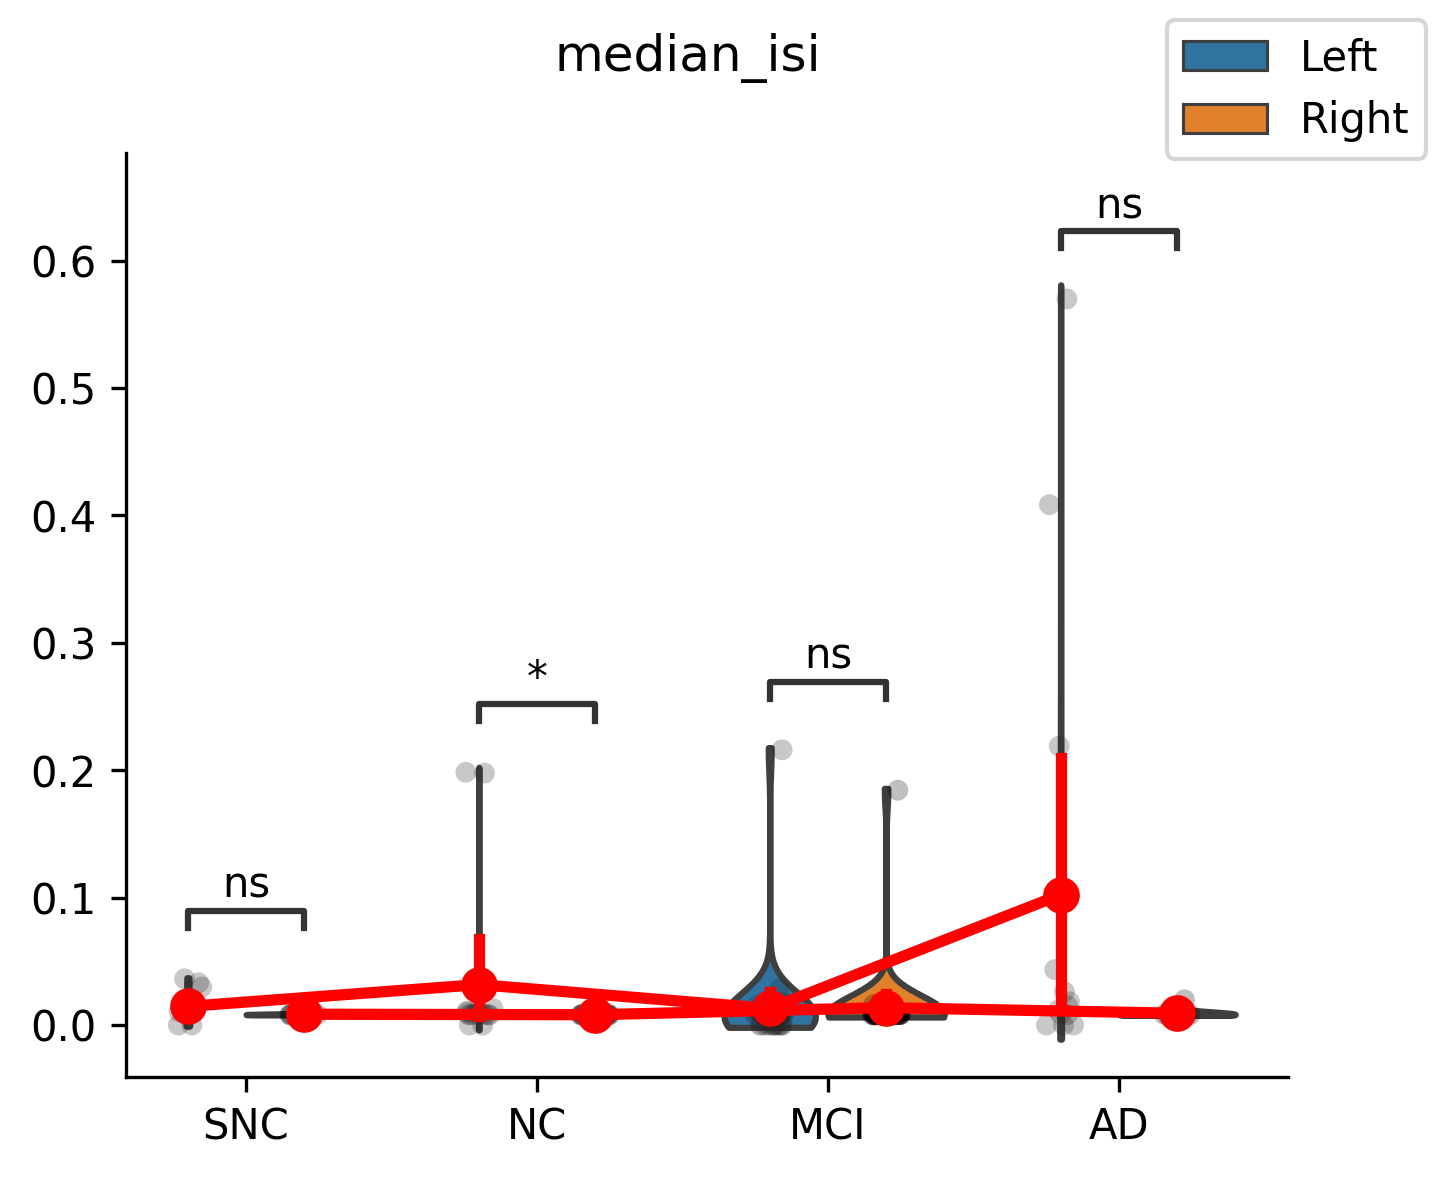

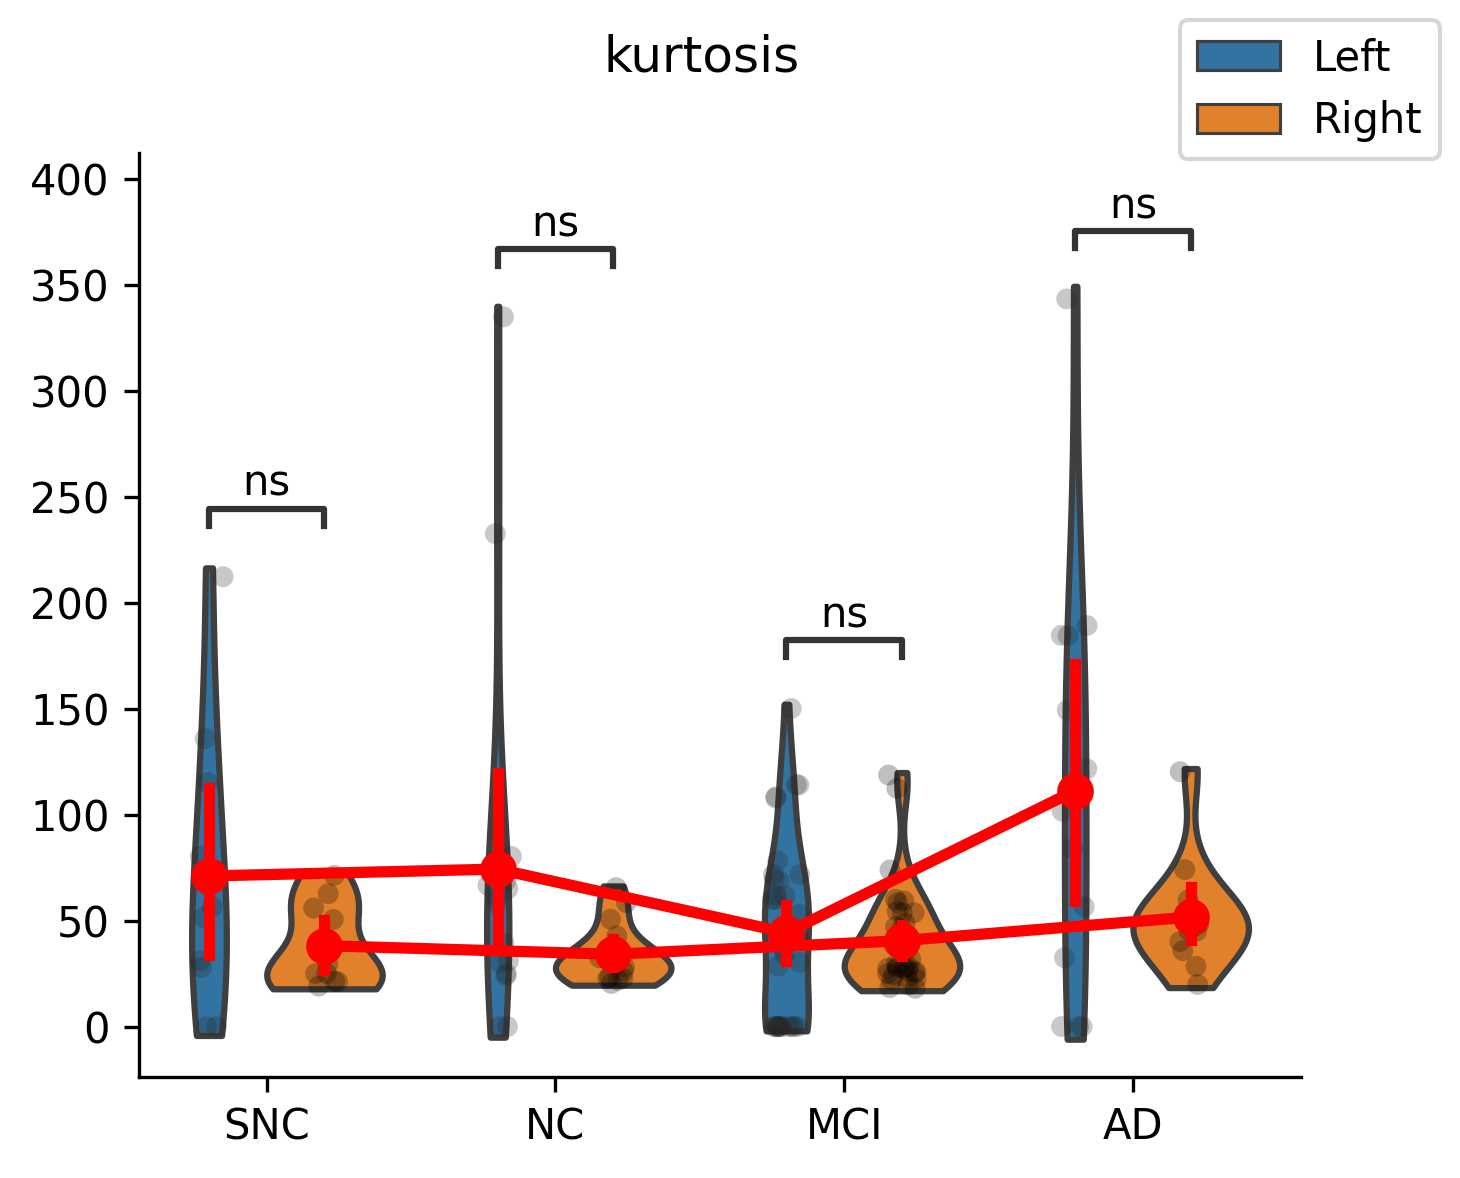

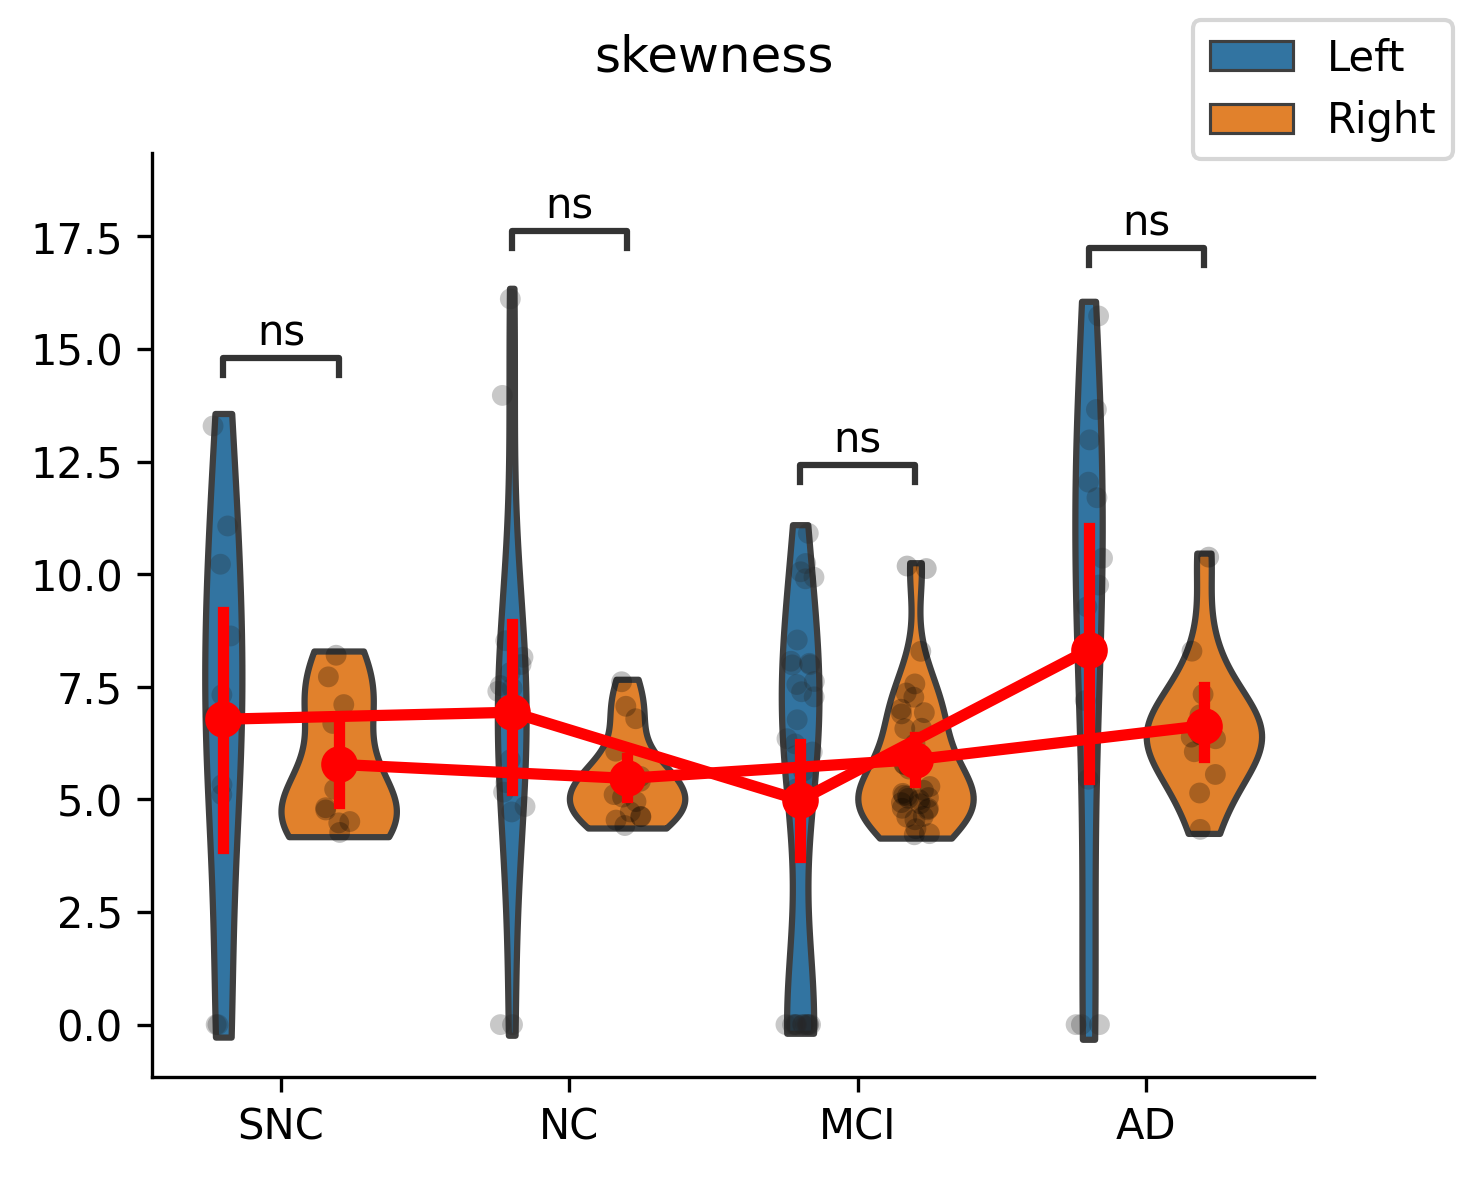

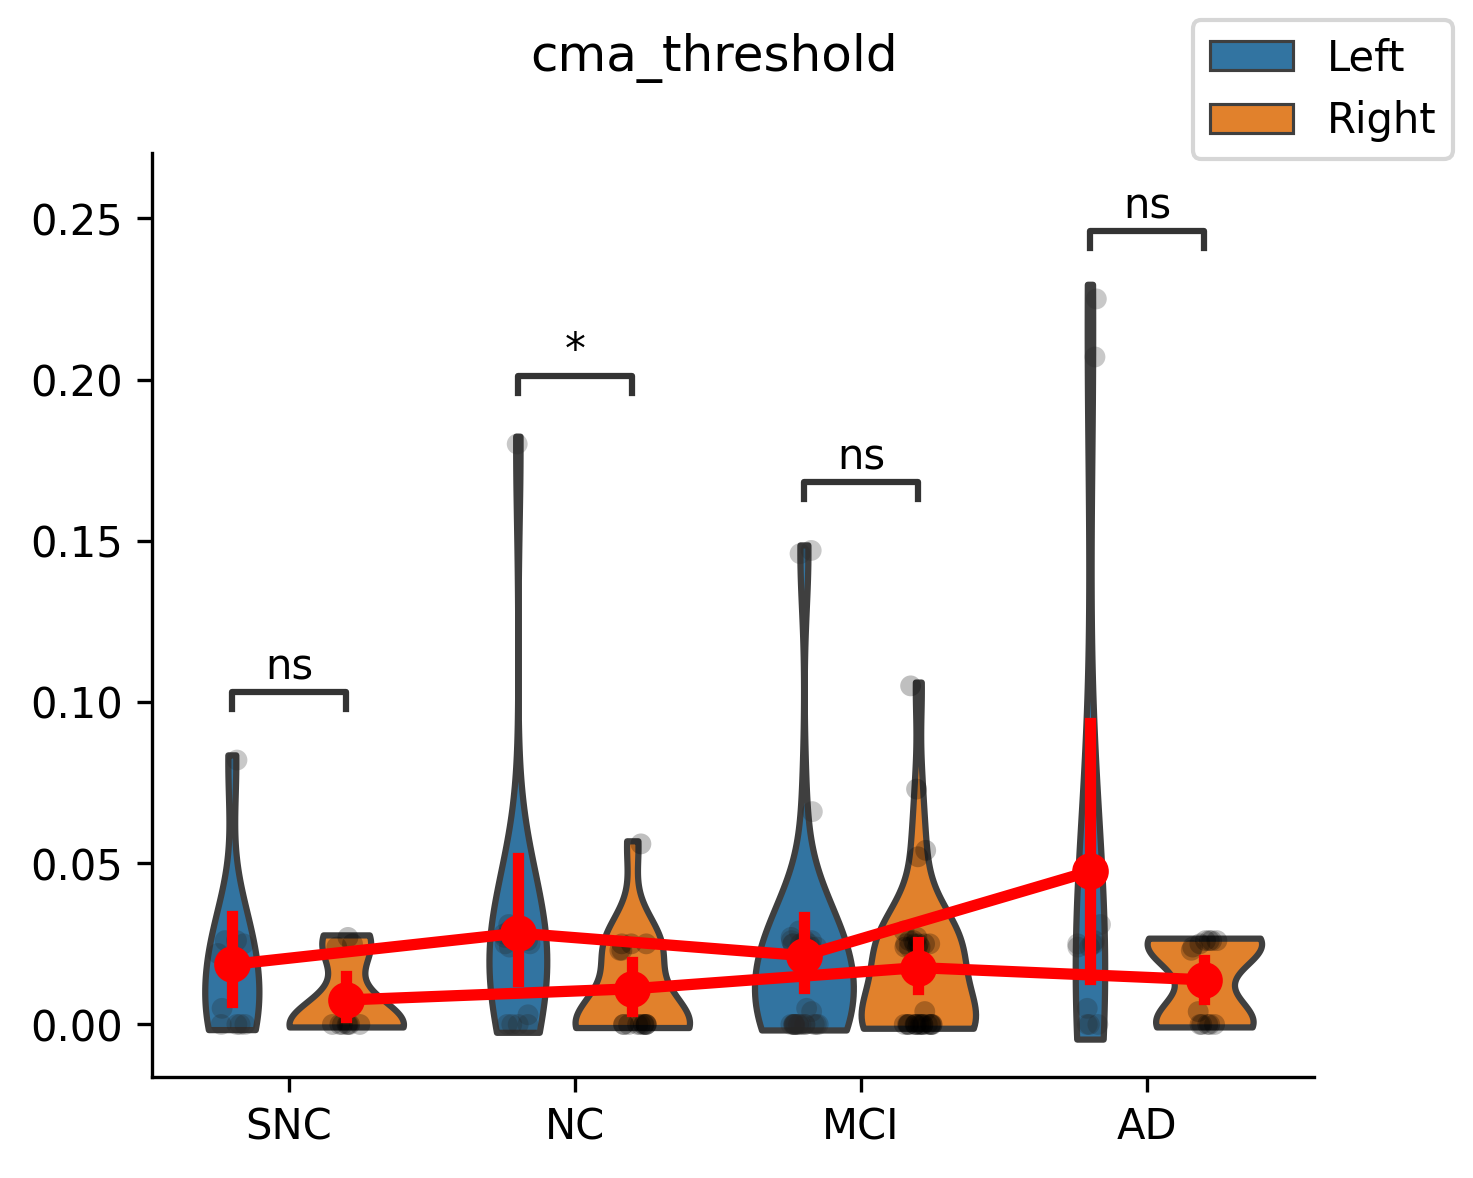

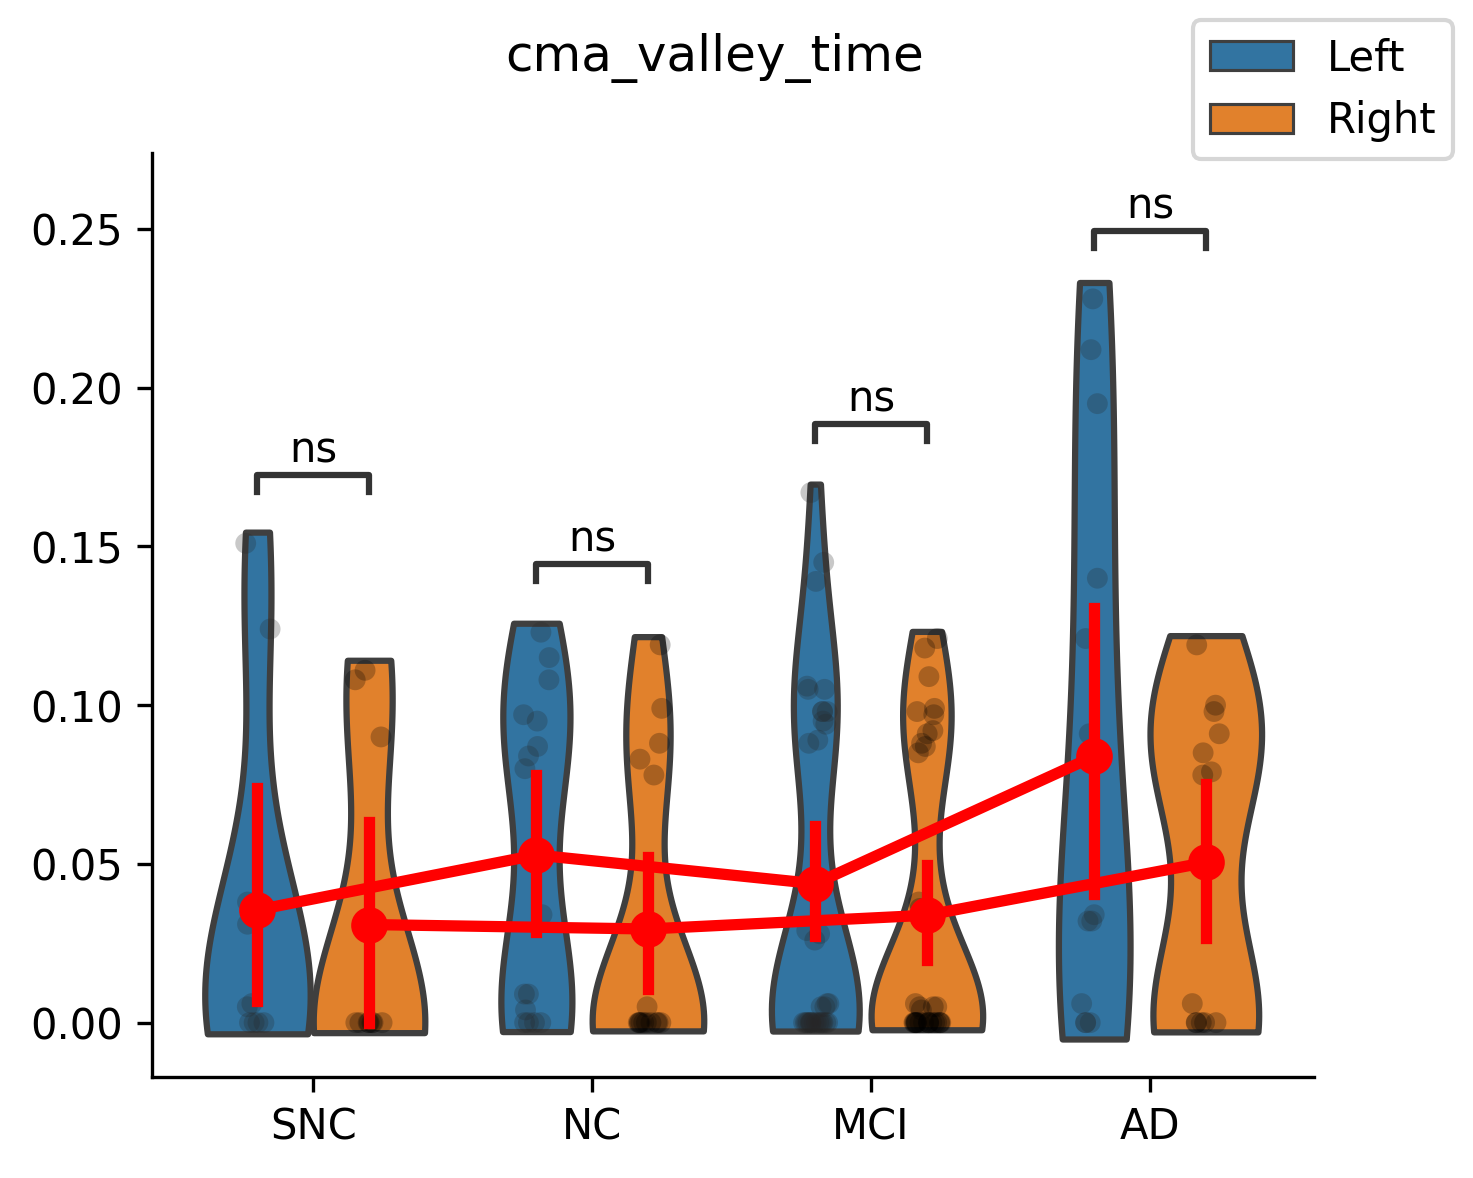

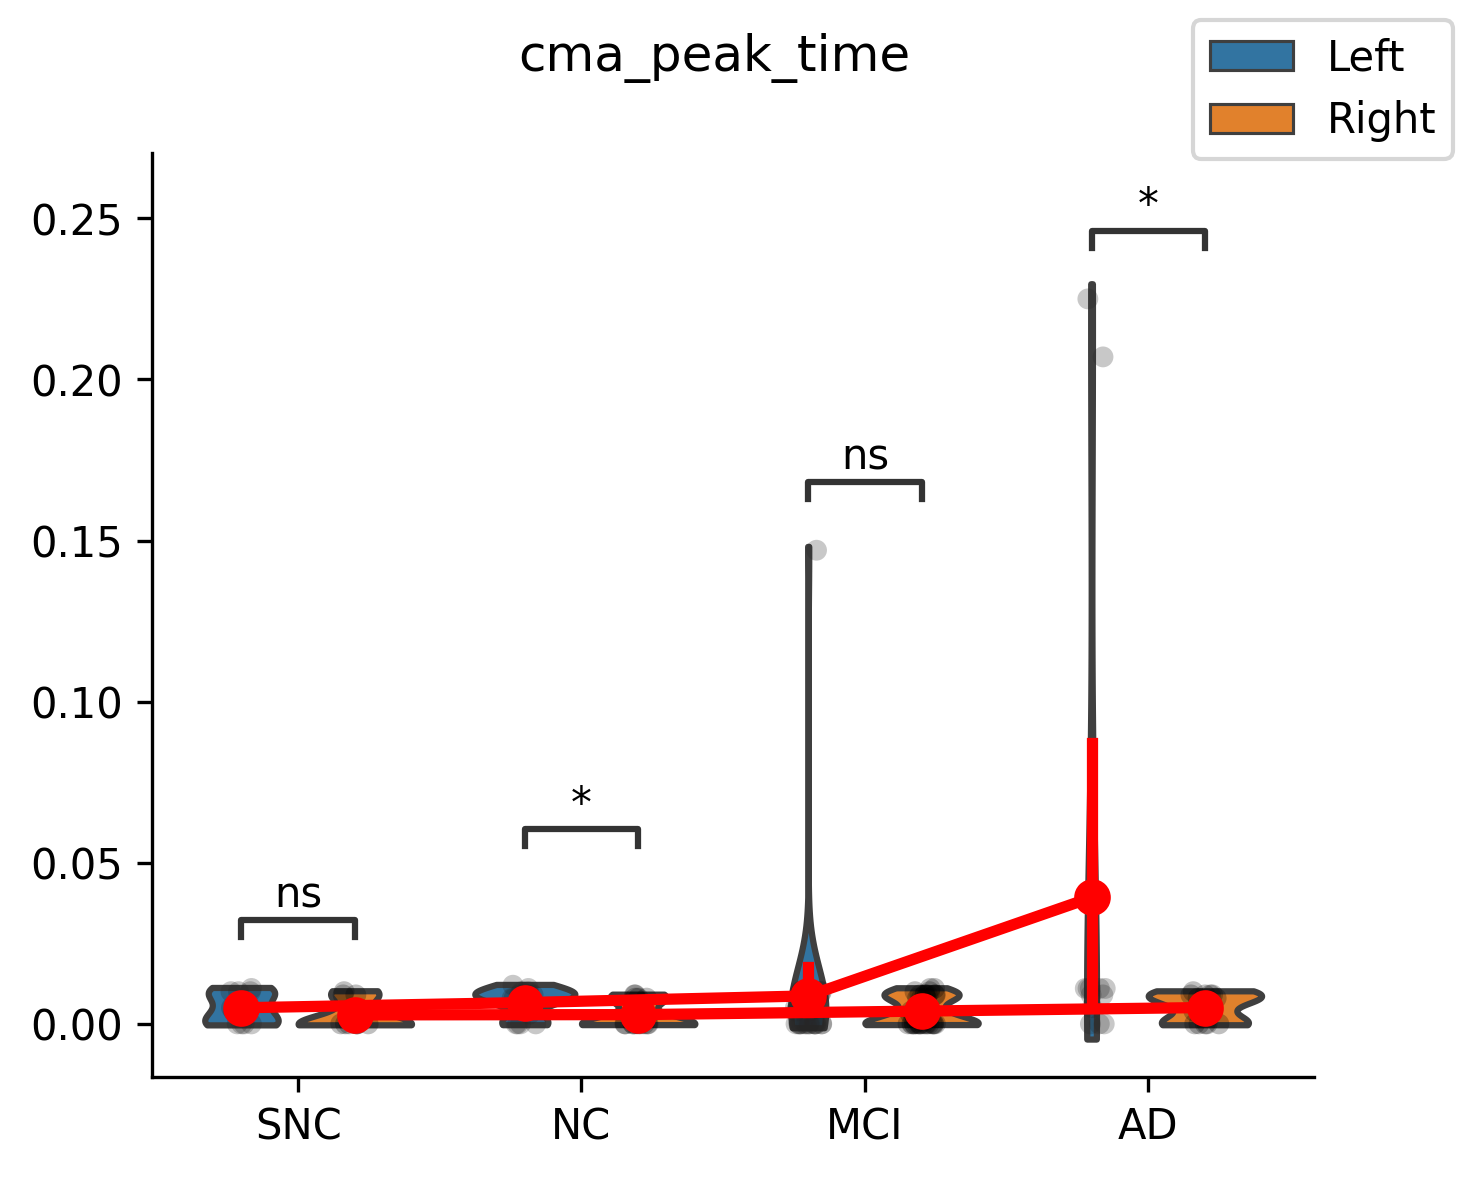

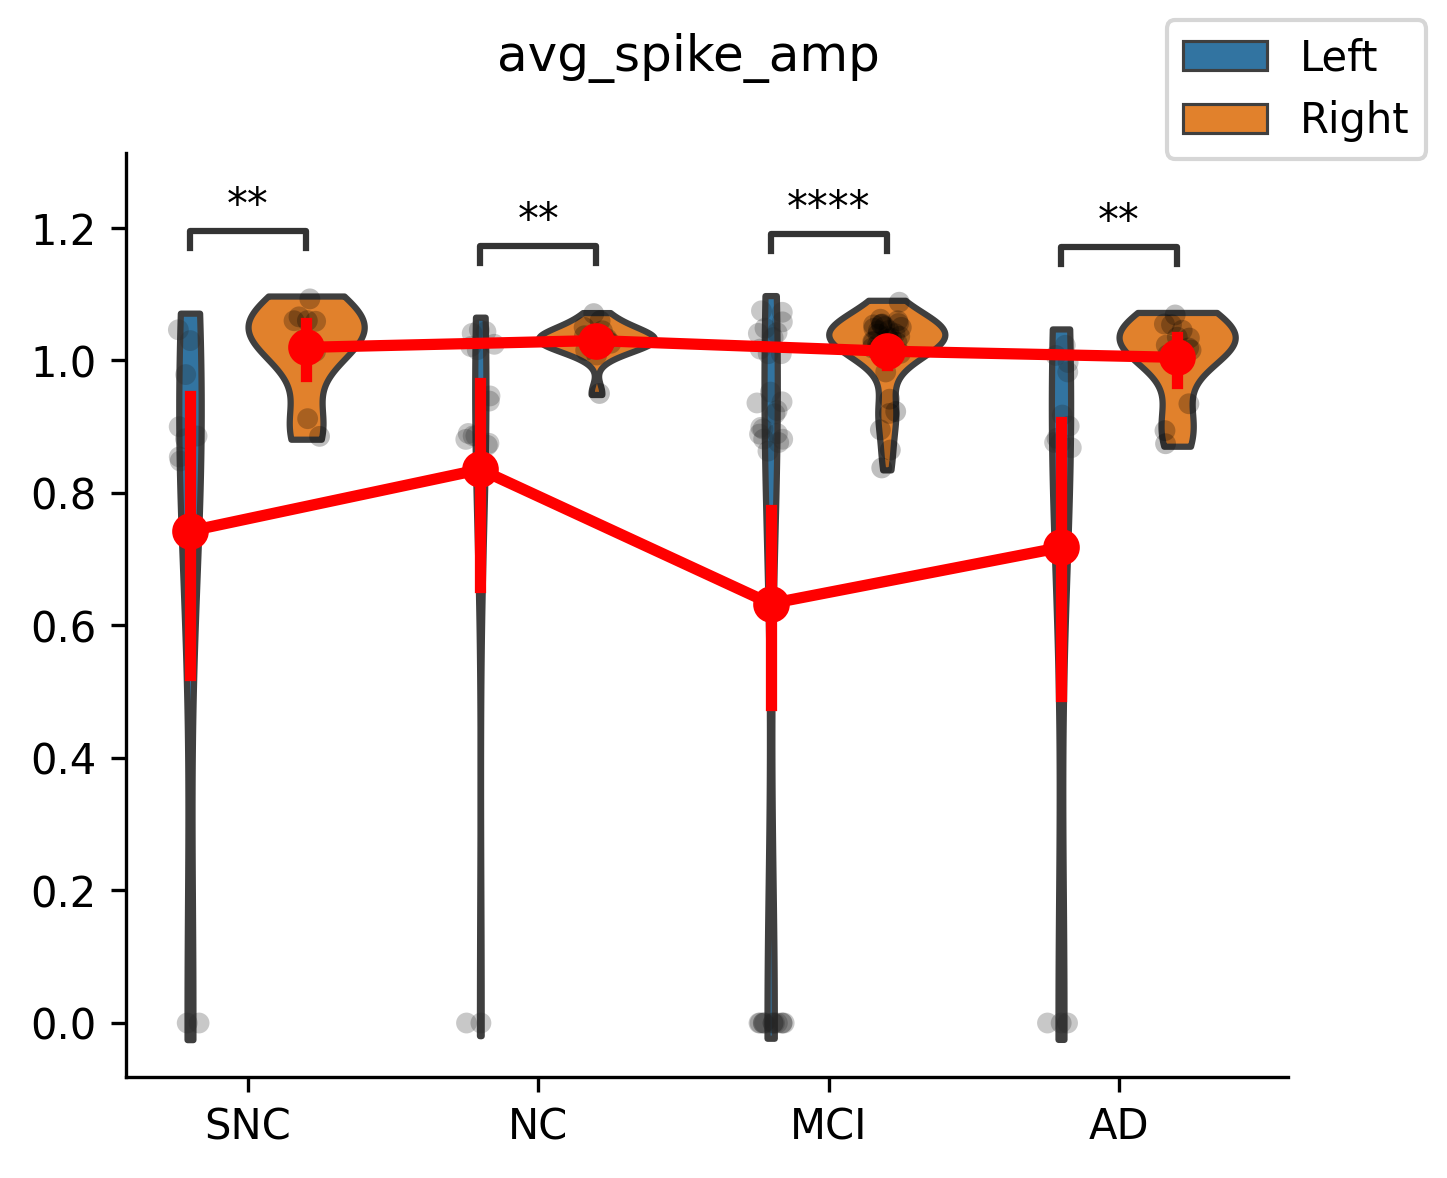

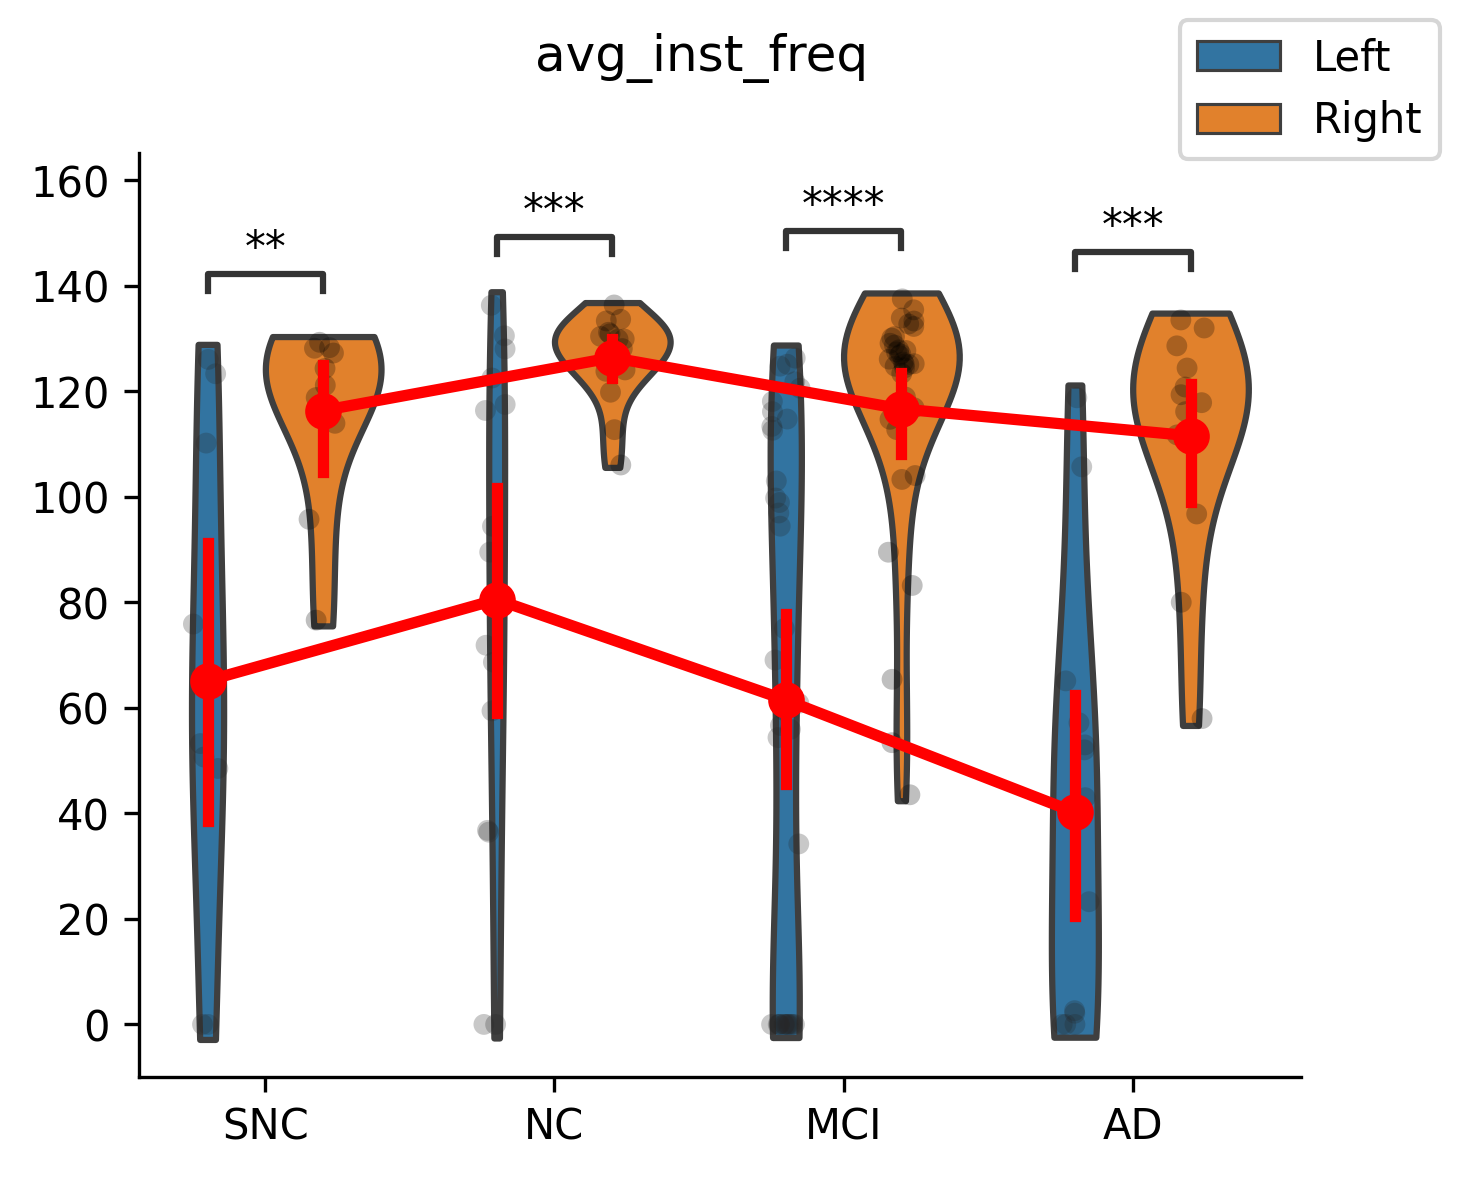

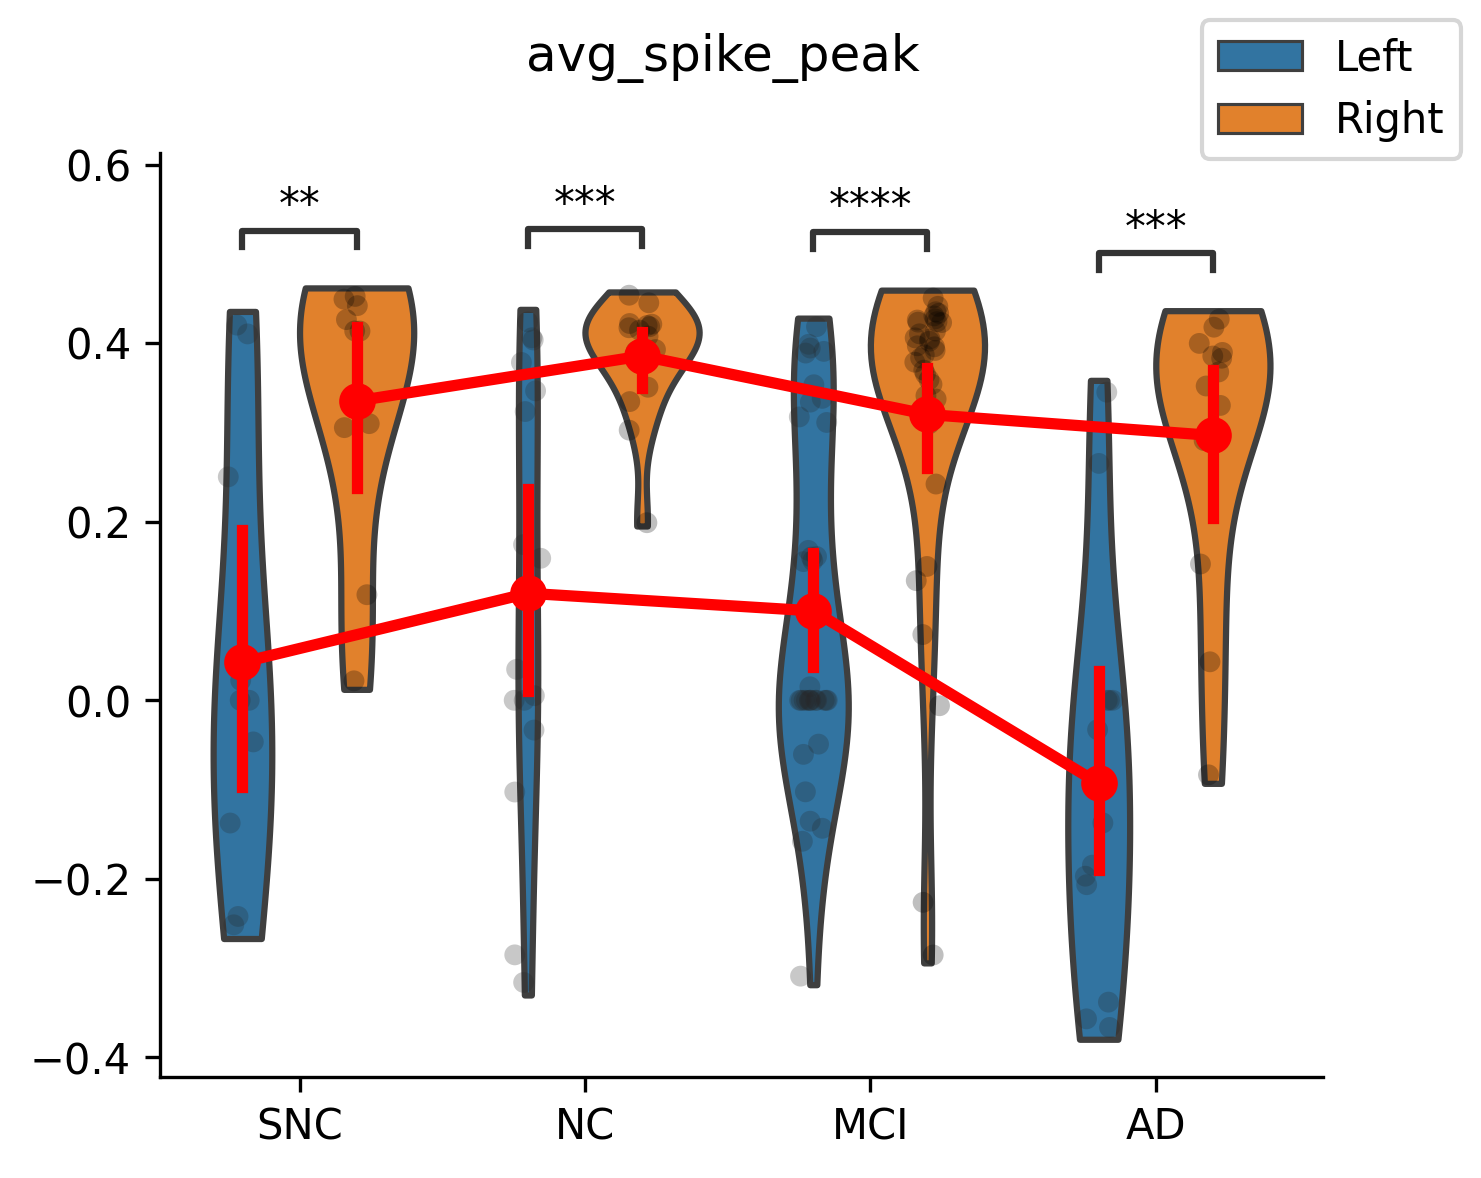

In [12]:
sides = ["Left"]*74 + ["Right"]*74
groups = np.concatenate((bursts_results_left["group"],bursts_results_right["group"]))



for var in col:
    figure = plt.figure(figsize=(5, 4), dpi=300)
    # concate upper_left and upper_right    
    values = np.concatenate((bursts_results_left[var],bursts_results_right[var]))
    sns.violinplot(x=groups, y=values, hue=sides, cut=0.1, inner = None)
    sns.stripplot(x=groups, y=values, hue=sides, dodge=True, jitter=True, palette='dark:black', alpha=0.25,zorder=1)
    sns.pointplot(x=groups, y=values, hue=sides, dodge=0.4, palette=["red", "red"], errorbar=None)
    plt.ylim(top=max(values)*1.1)  # Increase the max y limit by 10%
    plt.legend([],[], frameon=False)
    # only keep violinplot legend
    handles, labels = figure.gca().get_legend_handles_labels()
    figure.legend(handles[:2], labels[:2], loc='upper right')
    annot = Annotator(ax=figure.gca(),
        pairs=[(("SNC", "Left"), ("SNC", "Right")),(("NC", "Left"), ("NC", "Right")), (("MCI", "Left"), ("MCI", "Right")), (("AD", "Left"), ("AD", "Right"))],
        x=groups,
        y=values,
        hue=sides)
    annot.configure(
        test='Mann-Whitney',
        text_format="star")
    annot.apply_and_annotate()

    # hide top and right frame
    sns.despine(top=True, right=True)
    plt.suptitle(var)
    # automatically add spaces beyond y axis





In [ ]:
# bursts_results_left = pd.read_csv(pjoin(basedir, "bursts_results_left.csv"))
# bursts_results_right = pd.read_csv(pjoin(basedir, "bursts_results_right.csv"))
# ta = bursts_results_left
# col = ta.columns[3:]
# colors = ['#7F58AF','#64C5EB','#E84D8A','#FEB326']
colors = ["#66CDAA","#4682B4","#AB63FA","#FFA15A"]
for var in col:
    figure = plt.figure(figsize=(5, 4), dpi=300)
    print(var)
    sns.violinplot(x=bursts_results_left.group, y=abs(bursts_results_right[var] - bursts_results_left[var])/(bursts_results_right[var] + bursts_results_left[var]), cut=0, inner = None, palette=colors)
    sns.stripplot(x=bursts_results_left.group, y=abs(bursts_results_right[var] - bursts_results_left[var])/(bursts_results_right[var] + bursts_results_left[var]), dodge=True, jitter=True, color='black')
    sns.pointplot(x=bursts_results_left.group, y=abs(bursts_results_right[var] - bursts_results_left[var])/(bursts_results_right[var] + bursts_results_left[var]), color='r', errorbar=None)
    plt.ylabel("Absolute Laterality Index")
    # hide "group" label
    plt.xlabel("")
    # statannot.add_stat_annotation(
    #     ax=figure.gca(),
    #     x=bursts_results_left.group,
    #     y=abs(bursts_results_right[var] - bursts_results_left[var])/(bursts_results_right[var] + bursts_results_left[var]),
    #     box_pairs=[
    #         (("SNC"), ("NC")), (("NC", "AD"))],
    #     test='Mann-Whitney',
    #     text_format="star")

    # hide top and right frame
    sns.despine(top=True, right=True)
    plt.suptitle(var)
    # automatically add spaces beyond y axis

In [ ]:
small_burst = pd.DataFrame()
small_burst['group'] = bursts_results_left.group
small_burst['caseid'] = bursts_results_left.caseid
for i in col_names[3:]:
    small_burst[i] = abs(bursts_results_right[i] - bursts_results_left[i])/ (bursts_results_left[i] + bursts_results_right[i])
print(small_burst)

In [ ]:
import sys
from tvbtools.tools.statools import permutation_test, stats_calculator
stats_calculator(small_burst, tails="less")

In [ ]:
# colors = ['#7F58AF','#64C5EB','#E84D8A','#FEB326']
colors = ["#66CDAA","#4682B4","#AB63FA","#FFA15A"]
mega = pd.read_excel('/Users/yilewang/workspaces/data4project/mega_table.xlsx', sheet_name='tvb_parameters')
figure = plt.figure(figsize=(5, 4), dpi=300)
sns.violinplot(x="group", y="Gmax", data=mega, cut=0, inner = None, palette=colors)
sns.stripplot(x="group", y="Gmax", data = mega,dodge=True, jitter=True, color='black')
sns.pointplot(x="group", y="Gmax", data=mega, color='r', errorbar=None)
plt.ylabel("Global Coupling")
# hide "group" label
plt.xlabel("")
# statannot.add_stat_annotation(
#     ax=figure.gca(),
#     x=bursts_results_left.group,
#     y=abs(bursts_results_right[var] - bursts_results_left[var])/(bursts_results_right[var] + bursts_results_left[var]),
#     box_pairs=[
#         (("SNC"), ("NC")), (("NC", "AD"))],
#     test='Mann-Whitney',
#     text_format="star")

# hide top and right frame
sns.despine(top=True, right=True)
# plt.suptitle("Global Coupling (Maximum)")
# automatically add spaces beyond y axis